In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as Fun
from tqdm import tqdm

device = 'cuda'

# (A) Set-up parameters

In [2]:
# paths
dir_backgrounds = "./backgrounds/treebark_cropped15/" # path to background images
mask_name = './mask_triangle.tiff' # path to mask
dir_output = './output/' # path to output (will be created if it does not exist)

# image variables
num_sample_per_im = 32 # number of background samples per image
imsize = 256 # crop size from the background image
target_y = int(imsize/8) # 32
target_x = int(imsize/4) # 64

resize_factor = 1 # resize background image before cropping
batch_size = 16 # batch size

# (B) Generating samples as training set

## $\color{purple}{\text{(1) Process the mask (trangle)}}$

In [3]:
im_backgrounds = os.listdir(dir_backgrounds)
mask = cv2.imread(mask_name) # shape (32, 64, 3)
mask = cv2.resize(mask, (target_x, target_y), interpolation = cv2.INTER_NEAREST)

# Code below makes the mask contains only 1 for area of trangle, 0 for other places
# mask_inv contains only 0 for area of trangle, 1 for other places 

mask = np.float32(mask/255)
mask_inv = 1 - mask

## $\color{purple}{\text{(2) Declare data container}}$

In [4]:
# mask_holder, samples_empty is 0 (or random number, doesn't matter) everywhere

mask_holder = np.zeros((len(im_backgrounds*num_sample_per_im),mask.shape[0],mask.shape[1],3))
samples_container = np.zeros((len(im_backgrounds*num_sample_per_im),imsize,imsize,3))

In [5]:
print("mask shape:", end = " ")
print(mask.shape)
print("\nmask_holder shape:", end = " ")
print(mask_holder.shape)
print("\nsamples_container shape:", end = " ")
print(samples_container.shape)
print("\nThe first element in im_backgrounds is a string :", end = " ")
print(im_backgrounds[0])

mask shape: (32, 64, 3)

mask_holder shape: (3200, 32, 64, 3)

samples_container shape: (3200, 256, 256, 3)

The first element in im_backgrounds is a string : DSC_4256_cropped_r15.png


## $\color{purple}{\text{(3)  Randomly extracting crop image from tree image}}$

In [6]:
counter = 0
for index in range(len(im_backgrounds)):
    # the background image with arbitrary size
    path_background_image = dir_backgrounds + im_backgrounds[index]
    
    im = cv2.imread(path_background_image)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # convert to RGB, reason???
    
    # float32 is used here, you could change it to float64, slower but more accuate
    # im has arbitrary size (???, ???, 3), and entry value is [0,1]
    im = np.float32(im/255)
    if resize_factor != 1:
        # Resizing if needed, x becomes fx(x), y becomes fy(y)
        # Not nessesary since we extract graph from romdom position
        # If you did change the size, make sure it is greater than the crop_size
        im = cv2.resize(im, (0,0), fx = resize_factor, fy = resize_factor)
    for what_ever in range(num_sample_per_im):
        # generate random number from [0, side length - crop image length + 1]
        sample_x = random.randint(0, im.shape[0]-imsize-1)
        sample_y = random.randint(0, im.shape[1]-imsize-1)
        # extract small rectangle crop image
        samples_container[counter,:,:,:] = im[sample_x:sample_x+imsize, sample_y:sample_y+imsize,:]
        mask_holder[counter,:,:,:] = mask
        counter = counter + 1

## $\color{purple}{\text{(4)Randomly draw results}}$

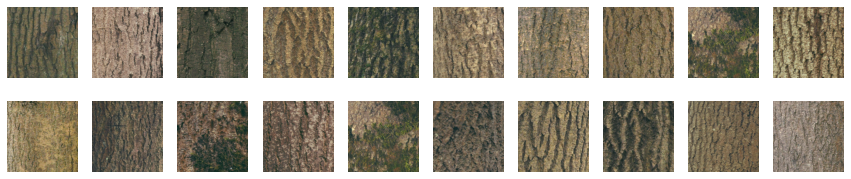

In [7]:
# Draw
plt.figure(figsize=(15,17))
for i in range(20):
    plt.subplot(10,10,i+1)
    rand = np.random.randint(0,len(samples_container))
    plt.imshow(samples_container[rand])
    plt.axis('off')

# (C) GAN network

In [25]:
def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

class gan(nn.Module):
    def __init__(self, samples_container, mask, mask_inv):
        super().__init__()
        self.Z_dim = 128
        self.losses_D = []
        self.losses_G = []
        self.Number_Channel = 3
        self.Number_Feature_Dis = 64
        self.Number_Feature_Gen = 64
        # Store the generated camoflage at some epoch
        self.Storage = []
        # Store the fake imgage (256* 256 but with target in the center) at some epoch
        self.Fake = []
        # These two are for line up test
        self.TrueLocation = 0
        self.chosen_fake = None
        
        # Keep a copy for giving fake image
        self.samples_container = torch.tensor(samples_container).permute(0, 3, 1, 2).detach().numpy()
        self.mask = torch.tensor(mask).permute(2, 0, 1).detach().numpy()
        self.mask_inv = torch.tensor(mask_inv).permute(2, 0, 1).detach().numpy()

        # D: Convolution part of the discriminator
        self.D = nn.Sequential(
            nn.Conv2d(self.Number_Channel, self.Number_Feature_Dis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis) x 128 x 128
            
            nn.Conv2d(self.Number_Feature_Dis, self.Number_Feature_Dis * 2, 4, 3, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*2) x 43 x 43
            
            nn.Conv2d(self.Number_Feature_Dis * 2, self.Number_Feature_Dis * 4, 3, 3, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*4) x 15 x 15
            nn.Conv2d(self.Number_Feature_Dis * 4, self.Number_Feature_Dis * 8, 5, 4, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*4) x 4 x 4
            nn.Conv2d(self.Number_Feature_Dis * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        # G: Generator, generating size differ from D
        self.G = nn.Sequential(
            
            nn.ConvTranspose2d(self.Z_dim, self.Number_Feature_Gen * 4, (4,8), (1,1), (0,0), bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 4),
            nn.ReLU(True),
            # (Number_Feature_Gen*4) x 4 x 8
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 4, self.Number_Feature_Gen * 2, (4,4), (2,2), (1,1), bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 2),
            nn.ReLU(True),
            # (Number_Feature_Gen*4) x 8 x 16
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 2, self.Number_Feature_Gen, (4,4), (2,2), (1,1), bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen),
            nn.ReLU(True),
            # (Number_Feature_Gen*2) x 16 x 32
            
            nn.ConvTranspose2d(self.Number_Feature_Gen, self.Number_Channel, (4,4), (2,2), (1,1), bias=False),
            # 3 * 32 * 64
            
            nn.Sigmoid()
        )
        self.D.to(device)
        self.G.to(device)
        
        self.Loss_D = nn.BCELoss()
        self.Loss_G = nn.BCELoss()
        self.G.apply(weights_init)
        self.D.apply(weights_init)
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.D(x)
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.randn(n, self.Z_dim, 1, 1, device=device)
        x = self.G(z).detach().cpu().numpy() * self.mask
        self.Storage.append(x)
        
    def Generating(self, timestamp = 1):
        plt.imshow(np.transpose(net.Storage[timestamp][np.random.randint(0, len(net.Storage[timestamp]))],(1,2,0)))
        
    def LineUpTest(self, timestamp = 1, scale = 1):
        real_index = np.random.randint(0, len(self.samples_container), size=20)
        data = self.samples_container[real_index, :, :, :]
        self.chosen_fake = self.Fake[timestamp][np.random.randint(0, len(self.Fake[timestamp]))].detach().cpu().numpy()
        net.TrueLocation = np.random.randint(0,20)
        data[self.TrueLocation] = self.chosen_fake
        plt.figure(figsize=(20*scale,20*scale))
        for i in range(20):
            plt.subplot(5,5,i+1)
            plt.imshow(np.transpose(data[i], (1,2,0)))
            plt.axis('off')
            
    
    def Reveal(self):
        print(self.TrueLocation + 1)
        plt.imshow(np.transpose(self.chosen_fake, (1,2,0)))
        
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optimizerD = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        optimizerG = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        for epoch in tqdm(range(epochs)):
            
            for x in dl:
                real_data = x.to(device, dtype=torch.float)
                batch_size = real_data.size(0)
                label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
                
                # (1) Update D network
                self.D.zero_grad()
                output = self.D(real_data).view(-1)
                errD_real = self.Loss_D(output, label) # label it as real image
                errD_real.backward()
                
                # generate fake image
                noise = torch.randn(batch_size, self.Z_dim, 1, 1, device=device)
                target = self.G(noise) # 32 * 64 first multiply mask, then padding
                target = target * torch.from_numpy(self.mask).to(device)
                
                padding = (int((imsize - target_x)/2),int((imsize - target_x)/2),int((imsize - target_y)/2), int((imsize - target_y)/2),0,0,0,0)
                padded_target = Fun.pad(target, padding, "constant", 0)
                
                # Saver to generate fake batch using random numbers instead of another dataloader
                fake_batch_index = np.random.randint(0, len(self.samples_container), size=batch_size)
                fake_batch = self.samples_container[fake_batch_index, :, :, :]
                # process here
                
                tlX = int(imsize/2-target_x/2)
                tlY = int(imsize/2-target_y/2)
                fake_batch[:, :,tlY:tlY+target_y,tlX:tlX+target_x] = fake_batch[:, :, tlY:tlY+target_y,tlX:tlX+target_x] * self.mask_inv
                fake_batch = torch.from_numpy(fake_batch).to(device)
                
                # pad the target with 0
                fake_data = padded_target + fake_batch
                fake_data = fake_data.to(device=device, dtype=torch.float)
                label.fill_(0.) # fake label
                
                f_image = fake_data.detach().clone()
                output = self.D(f_image).view(-1) 
                
                # Train D with fake image, fake label
                errD_fake = self.Loss_D(output, label)
                errD_fake.backward()
                errD = errD_real + errD_fake
                optimizerD.step()
                
                # Train G
                self.G.zero_grad()        
                label.fill_(1.)  # label real, same fake imgae
                output = self.D(fake_data).view(-1)
                errG = self.Loss_G(output, label)
                errG.backward()
                optimizerG.step()
                
                self.losses_D.append(errD.item())
                self.losses_G.append(errG.item())
            if epoch % 1 == 0 and epoch != 0:
                self.generate(n=10)
            if epoch % 1 == 0 and epoch != 0:
                self.Fake.append(f_image)
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

# (D) Training

100%|██████████| 5/5 [01:00<00:00, 12.03s/it]


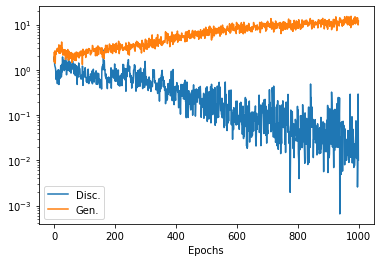

In [26]:
net = gan(samples_container, mask, mask_inv)
dl = torch.utils.data.DataLoader(net.samples_container, batch_size=batch_size, shuffle=True)
net.learn(dl, epochs=5, lr=0.0001)

# (E) Testing

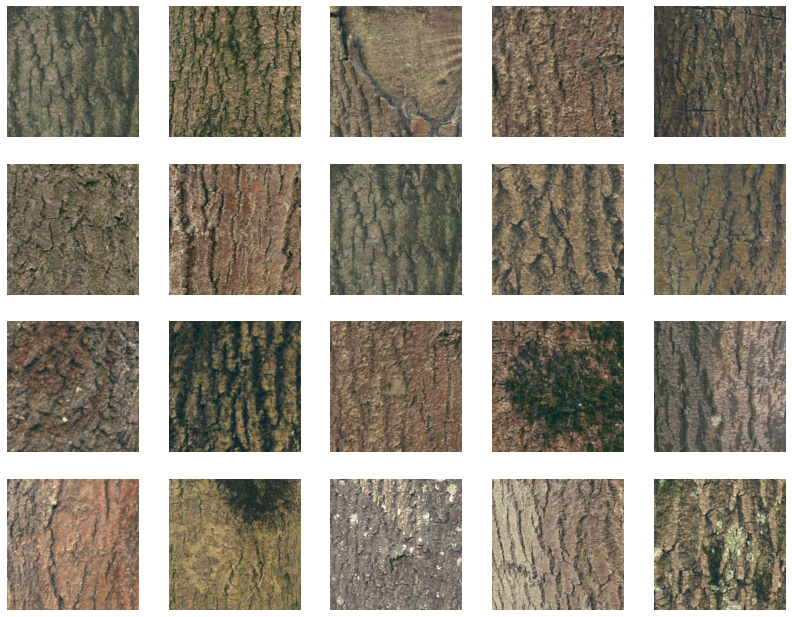

In [27]:
# Lineup test from statistics
# one of 20 images is fake 
# if you can't find that out, meaning at that epoch, the generator gives a somehow good result
net.LineUpTest(timestamp=0, scale = 0.7)

13


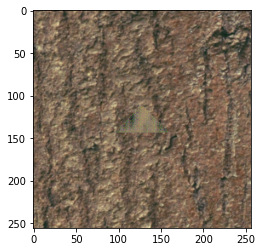

In [28]:
# Reveal the true location of fake image
net.Reveal()

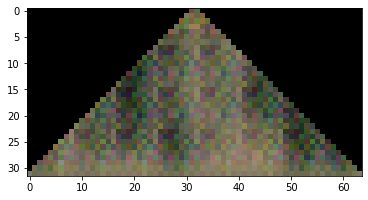

In [29]:
# Generate single comouflage at some epoch
net.Generating(timestamp = 0)